# REINFORCE in TensorFlow (3 pts)¶

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import collections

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym
env = gym.make("CartPole-v0")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

print(state_dim, n_actions)

[2017-10-02 01:22:36,961] Making new env: CartPole-v0


(4,) 2


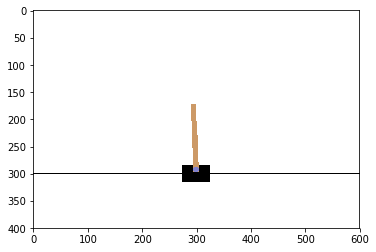

In [3]:
plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [4]:
import tensorflow as tf
tf.reset_default_graph()

#create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32', (None,)+state_dim, name="states")
print("the shape of state placeholder:", (None,)+state_dim)
actions = tf.placeholder('int32', name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

the shape of state placeholder: (None, 4)


In [5]:
# <define network graph using raw tf or any deep learning library>
hidden_size = 20

W1 = tf.get_variable("w1", [state_dim[0], hidden_size])
b1 = tf.get_variable("b1", [hidden_size])
h1 = tf.nn.sigmoid(tf.matmul(states, W1) + tf.reshape(b1, [1, -1]))

W2 = tf.get_variable("w2", [hidden_size, n_actions])
b2 = tf.get_variable("b2", [n_actions])
logits = tf.matmul(h1, W2) + tf.reshape(b2, [1, -1])

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

In [6]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0] 

#### Loss function and updates

We now need to define objective and update over policy gradient.

The objective function can be defined thusly:

$$ J \approx \sum  _i log \pi_\theta (a_i | s_i) \cdot R(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [7]:
#REINFORCE objective function

#<define intermediate variables>
action_mask = tf.one_hot(actions, depth=n_actions)
log_policy_action = tf.reduce_sum(log_policy*action_mask, axis=1)
#<define policy gradient using tutorial above>
J = tf.reduce_sum(log_policy_action * cumulative_rewards)

In [8]:
#regularize with entropy
entropy = -1 * tf.reduce_mean(policy*log_policy)

In [9]:
#all network weights
#all_weights = <a list of all trainable weights in your network>

#weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J -0.1*entropy

update = tf.train.AdamOptimizer().minimize(loss) #var_list=all_weights

### Computing cumulative rewards

In [10]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    #<your code here>
    s = 0
    length = len(rewards)
    result = [0] * length
    
    for i, r in enumerate(reversed(rewards)):
        s = r + gamma * s
        result[i] = s

    return [r for r in reversed(result)]
    
    

In [11]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [12]:
def train_step(_states,_actions,_rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states:_states,actions:_actions,cumulative_rewards:_cumulative_rewards})

### Playing the game

In [13]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [], [], []
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        
        #<pick random action using action_probas>
        a = np.random.choice(range(n_actions), p=action_probas)
        
        new_s, r, done, info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states, actions, rewards)
            
    return sum(rewards)
        

In [14]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(50):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        


mean reward:10.160
mean reward:10.540
mean reward:14.450
mean reward:28.410
mean reward:33.570
mean reward:40.090
mean reward:38.620
mean reward:42.890
mean reward:44.040
mean reward:44.110
mean reward:51.580
mean reward:51.490
mean reward:54.580
mean reward:55.600
mean reward:68.540
mean reward:71.920
mean reward:80.960
mean reward:92.640
mean reward:120.820
mean reward:147.370
mean reward:161.090
mean reward:163.480
mean reward:164.070
mean reward:176.540
mean reward:178.000
mean reward:174.630
mean reward:176.260
mean reward:167.020
mean reward:187.730
mean reward:182.780
mean reward:177.480
mean reward:161.430
mean reward:181.610
mean reward:187.280
mean reward:195.010
mean reward:169.350
mean reward:182.020
mean reward:193.210
mean reward:195.620
mean reward:191.180
mean reward:189.020
mean reward:187.230
mean reward:187.750
mean reward:193.590
mean reward:198.790
mean reward:198.060
mean reward:188.860
mean reward:190.650
mean reward:167.820
mean reward:186.800


### Results & video

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [ ]:
#That's all, thank you for your attention!